<a href="https://colab.research.google.com/github/bjpeters2/bjpeters2/blob/main/email_spam_filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

This is a basic natural language processing exercise that arose out of several assignments in my coding courses. It utilizes a Kaggle database (see link below) of email messages that are pre-coded as spam or not spam. After initial cleaning and characterization of the data, it attempts to build a predictive spam filter in three ways:
- Using a "naive" filter based on Bayes' Theorem in which the probability of each word being used in a spam or non-spam message is calculated, and then these probabilities are used to make a prediction about whether a new email is spam or not based on the words that appear in that email.
- Using sequential models with shallow and deep neural networks and a variety of layers
- Using a Distilbert transformer model

The success of each of these models and their various options are evaluated in each sub-section, with a conclusion written at the end.

Link to Kaggle dataset:
https://www.kaggle.com/datasets/jackksoncsie/spam-email-dataset

# **1. Data import, cleaning, and basic description**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB
Database information: None 



,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [ ]:
# Import dataset and print basic features
import pandas as pd
emails = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Email spam filter/emails.csv')
print('Database information:', emails.info(), '\n')
emails.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB
Database information: None 



,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


24.0% of the messages are spam, 76.0% are not spam


Text(0.5, 1.0, 'Breakdown of spam and non-spam emails')

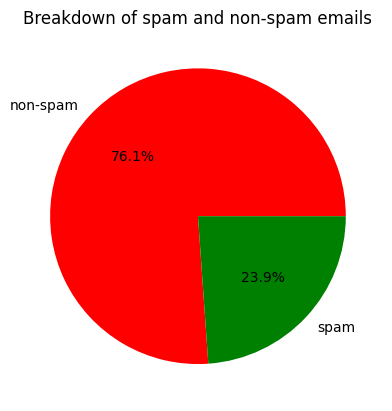

In [ ]:
# Determine proportion of spam and non-spam messages
percent_spam = round(emails['spam'].value_counts()[1] / len(emails) * 100, 0)
percent_ham = 100 - percent_spam
print('{}% of the messages are spam, {}% are not spam'.format(percent_spam, percent_ham))

# Visualize results
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.pie(emails['spam'].value_counts(normalize=True), labels=['non-spam', 'spam'], autopct='%1.1f%%',
        colors=['red', 'green'])
ax.set_title('Breakdown of spam and non-spam emails')

In [ ]:
# Remove 'Subject: ' from all text
emails['text'] = emails['text'].str.replace('Subject: ', '')

# Test that text is removed correctly
emails.head()

,text,spam
0,naturally irresistible your corporate identity...,1
1,the stock trading gunslinger fanny is merrill...,1
2,unbelievable new homes made easy im wanting t...,1
3,4 color printing special request additional i...,1
4,"do not have money , get software cds from here...",1


In [ ]:
# Remove punctuation and numbers from all text and make lowercase
import re

def clean_text(message):
  message = re.sub(r'[^a-zA-Z]', ' ', message)
  message = re.sub(r'[0-9]', ' ', message)
  message = message.lower()
  return message

emails['text'] = emails['text'].apply(clean_text)

# Test that punctuation is removed correctly and all text is lowercase
emails.head(10)

,text,spam
0,naturally irresistible your corporate identity...,1
1,the stock trading gunslinger fanny is merrill...,1
2,unbelievable new homes made easy im wanting t...,1
3,color printing special request additional i...,1
4,do not have money get software cds from here...,1
5,great nnews hello welcome to medzonline sh ...,1
6,here s a hot play in motion homeland securi...,1
7,save your money buy getting this thing here y...,1
8,undeliverable home based business for grownu...,1
9,save your money buy getting this thing here y...,1


In [ ]:
# Tokenize words and remove stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = stopwords.words('english')

def tokenize_removestops(message):
  message = word_tokenize(message)
  return [word for word in message if word not in stop_words]

emails['text'] = emails['text'].apply(tokenize_removestops)

# Check that tokenization and stopword removal was successful
emails.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,text,spam
0,"[naturally, irresistible, corporate, identity,...",1
1,"[stock, trading, gunslinger, fanny, merrill, m...",1
2,"[unbelievable, new, homes, made, easy, im, wan...",1
3,"[color, printing, special, request, additional...",1
4,"[money, get, software, cds, software, compatib...",1
5,"[great, nnews, hello, welcome, medzonline, sh,...",1
6,"[hot, play, motion, homeland, security, invest...",1
7,"[save, money, buy, getting, thing, tried, cial...",1
8,"[undeliverable, home, based, business, grownup...",1
9,"[save, money, buy, getting, thing, tried, cial...",1


In [ ]:
# Lemmatize words
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_words(message):
  return [lemmatizer.lemmatize(word=word, pos='v') for word in message]

emails['text']= emails['text'].apply(lemmatize_words).str.join(' ')

# Check that lemmatization was successful
emails['text'].head(10)

,text
0,naturally irresistible corporate identity lt r...
1,stock trade gunslinger fanny merrill muzo colz...
2,unbelievable new home make easy im want show h...
3,color print special request additional informa...
4,money get software cds software compatibility ...
5,great nnews hello welcome medzonline sh ground...
6,hot play motion homeland security investments ...
7,save money buy get thing try cialls yet even i...
8,undeliverable home base business grownups mess...
9,save money buy get thing try cialls yet even i...


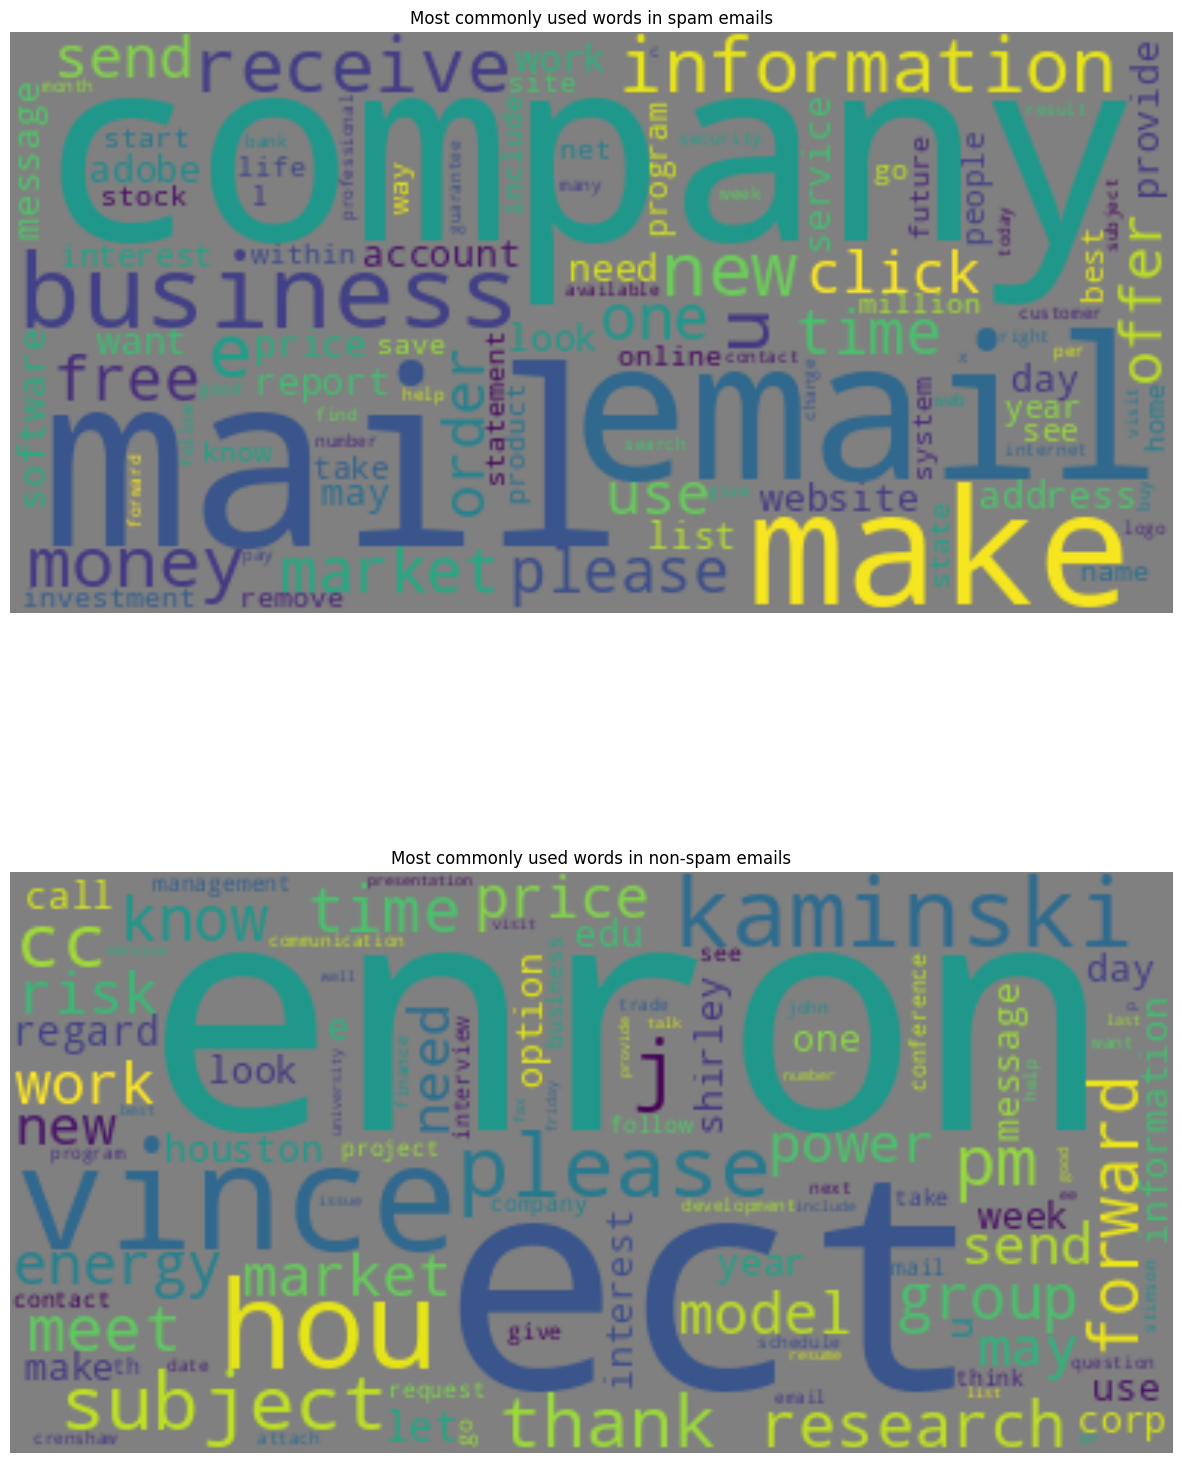

In [ ]:
# Create word maps for spam and non-spam emails
# Isolate spam and non-spam emails into separate DataFrames
emails_spam = emails[emails['spam'] == 1]
emails_ham = emails[emails['spam'] == 0]

# Combine all words from spam and non-spam emails into individual lists
emails_spam_words = emails_spam['text'].explode().value_counts()
emails_ham_words = emails_ham['text'].explode().value_counts()

emails_spam_text = ' '.join([word for word in emails_spam_words.index])
emails_ham_text = ' '.join([word for word in emails_ham_words.index])

# Produce word maps
from wordcloud import WordCloud
wordcloud_spam = WordCloud(max_words=100, random_state=100, background_color='gray', collocations=False).generate(emails_spam_text)
wordcloud_ham = WordCloud(max_words=100, random_state=100, background_color='gray', collocations=False).generate(emails_ham_text)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))

ax1.imshow(wordcloud_spam, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Most commonly used words in spam emails')

ax2.imshow(wordcloud_ham, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Most commonly used words in non-spam emails')

plt.show()



The most commonly used words in spam and non-spam emails are different. Spam emails make more reference to business- and money-related terms and more frequently use general technologz terms like 'online', 'click', 'adobe', or 'website'. Non-spam emails use a greater variety of words related to different subjects and often include specific names.

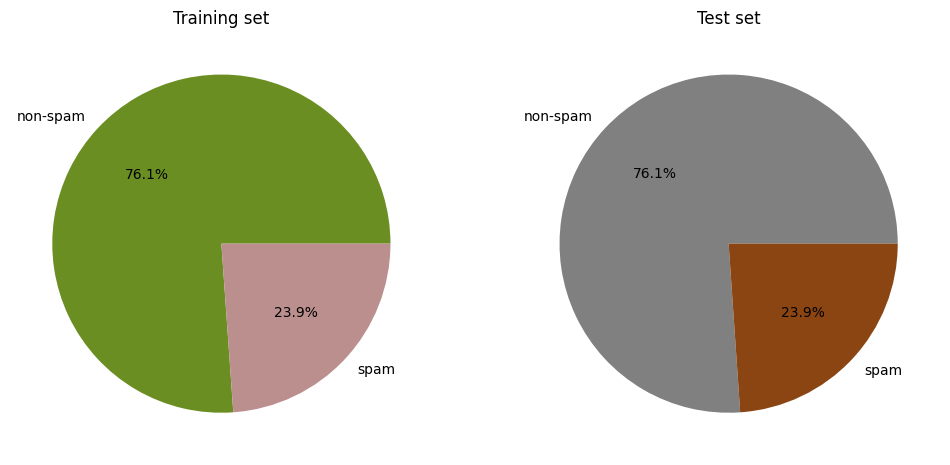

In [ ]:
# Split database into training (80% of data) and test (20% of data) sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(emails, test_size=0.2, random_state=23, shuffle=True, stratify=emails['spam'])

# Visualize split datsets to ensure correct randomization and stratification
import matplotlib.pyplot as plt

train_prop = train['spam'].value_counts(normalize=True)
test_prop = test['spam'].value_counts(normalize=True)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1.pie(train_prop, labels=['non-spam', 'spam'], autopct='%1.1f%%',
        colors=['olivedrab', 'rosybrown'])
ax1.set_title('Training set')
ax2.pie(test_prop, labels=['non-spam', 'spam'], autopct='%1.1f%%',
        colors=['gray', 'saddlebrown'])
ax2.set_title('Test set')
plt.show()

# **2. Naive Bayes spam filter**

In [ ]:
# Create vocabulary list
train_bayes = train.copy()
train_bayes['split_text'] = train_bayes['text'].str.split()

vocabulary = []

for message in train_bayes['split_text']:
  for word in message:
    vocabulary.append(word)

# Remove duplicates in vocabulary list
vocabulary = list(set(vocabulary))

# Print results
print('There are {} unique words in the vocabulary'.format(len(vocabulary)))

There are 26949 unique words in the vocabulary


In [ ]:
# Count occurences of each word in vocabulary within email messages
word_counts_per_email = {word: [0] * len(train_bayes['split_text']) for word in vocabulary}

for index, message in enumerate(train_bayes['split_text']):
  for word in message:
    word_counts_per_email[word][index] += 1

word_counts = pd.DataFrame(word_counts_per_email)
word_counts.head()

,houstonu,jochenfechtel,recall,kmi,angie,ignite,aiways,webtransit,copyright,baskets,...,oeg,seb,pulse,faris,agarwal,weathereffects,ripe,bedrooms,andras,grannys
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Remove 'text' column from training set and rename spam column to avoid column duplicates when merging
train_bayes = train_bayes.drop(columns='text')
train_bayes = train_bayes.rename(columns={'spam': 'spam_label'})

# Create DataFrame with original messages and word list together
train_bayes_counts = pd.concat([train_bayes, word_counts], axis=1).reset_index(drop=True)

# Verify correct concatenation
train_bayes_counts.head()

,spam_label,split_text,houstonu,jochenfechtel,recall,kmi,angie,ignite,aiways,webtransit,...,oeg,seb,pulse,faris,agarwal,weathereffects,ripe,bedrooms,andras,grannys
0,0.0,"[confirmation, order, automatic, confirmation,...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,"[carnegie, mellon, kristin, presentation, go, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,"[conference, monetary, policy, new, economy, m...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,"[wharton, fap, webcafe, access, month, ago, re...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,"[part, time, work, vince, zimin, talk, briefly...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Calculate probability of occurence of spam or non-spam messages
p_spam = train_bayes_counts['spam_label'].sum() / len(train_bayes_counts)
p_ham = 1 - p_spam

# Calculate word counts of spam and non-spam messages
n_spam = train_bayes_counts[train_bayes_counts['spam_label'] == 1]['split_text'].apply(len).sum()
n_ham = train_bayes_counts[train_bayes_counts['spam_label'] == 0]['split_text'].apply(len).sum()

# Calculate number of words in vocabulary
n_vocabulary = len(vocabulary)

# Set Laplace smoothing
alpha = 1

# Check magnitude of variables for correctness
print('Probabilty a message is spam:', p_spam)
print('Probabilty a message is not spam:', p_ham)
print('Number of words in spam messages:', n_spam)
print('Number of words in non-spam messages:', n_ham)
print('Number of words in vocabulary:', n_vocabulary)

Probabilty a message is spam: 0.19963503649635037
Probabilty a message is not spam: 0.8003649635036496
Number of words in spam messages: 128694
Number of words in non-spam messages: 504043
Number of words in vocabulary: 26949


In [ ]:
# Initialize dictionaries for counting probabilities of each word occurring in a spam or non-spam message
p_words_spam = {word: [0] * len(train_bayes_counts['split_text']) for word in vocabulary}
p_words_ham = {word: [0] * len(train_bayes_counts['split_text']) for word in vocabulary}

# Isolate spam and non-spam messages into separate DataFrames
train_counts_spam = train_bayes_counts[train_counts['spam_label'] == 1]
train_counts_ham = train_bayes_counts[train_counts['spam_label'] == 0]

# Iterate over vocabulary list and calculate counts of each word
for word in vocabulary:
  n_word_spam = train_counts_spam[word].sum()
  p_words_spam[word] = (n_word_spam + alpha) / (n_spam + alpha * n_vocabulary)

  n_words_ham = train_counts_ham[word].sum()
  p_words_ham[word] = (n_words_ham + alpha) / (n_ham + alpha * n_vocabulary)

In [ ]:
# Define a function to calculate probability of a new email being spam
def classify(message):
  # Ensure message is cleaned the same as the test set
  message = re.sub(r'[^\w\s]', '', message)
  message = message.lower()
  message = message.split()

  p_spam_message = p_spam
  p_ham_message = p_ham

  for word in message:
    if word in vocabulary:
      p_spam_message *= p_words_spam[word]
      p_ham_message *= p_words_ham[word]
    else:
      p_spam_message = p_spam_message
      p_ham_message = p_ham_message

  if p_spam_message > p_ham_message:
    print('Label: Spam')
  elif p_ham_message > p_spam_message:
    print('Label: Not spam')
  else:
    print('Equal probability spam or non-spam, requires human classification')

# Test function with example messages
classify('WINNER!! This is the secret code to unlock the money: C3421.')
classify('Sounds good, Tom, then see u there')

Label: Spam
Label: Not spam


In [ ]:
# Reformat function for returning many classifcations
def classify_set(message):
  # Ensure message is cleaned the same as the test set
  message = re.sub(r'[^\w\s]', '', message)
  message = message.lower()
  message = message.split()

  p_spam_message = p_spam
  p_ham_message = p_ham

  for word in message:
    if word in vocabulary:
      p_spam_message *= p_words_spam[word]
      p_ham_message *= p_words_ham[word]
    else:
      p_spam_message = p_spam_message
      p_ham_message = p_ham_message

  if p_spam_message > p_ham_message:
    return 1
  elif p_ham_message > p_spam_message:
    return 0
  else:
    return 0

# Apply function to test set
test_bayes = test.copy()
test_bayes['spam_predicted'] = test_bayes['text'].apply(classify_set)

# Print output to ensure correct function
test_bayes.head()

,text,spam,spam_predicted
763,ilug business central bank nigeria foreign rem...,1,0
4922,candidate intern bryan please take look resume...,0,0
795,get ink know sick tire go store find printer c...,1,0
3260,good morning afternoon vince one colleagues ba...,0,0
4744,real options conference program ucla july plea...,0,0


In [ ]:
# Calculate accuracy of spam filter
correct = 0
total = len(test)

for row in test_bayes.iterrows():
  row = row[1]
  if row['spam'] == row['spam_predicted']:
    correct += 1

accuracy = round(correct / total * 100, 1)

print('The accuracy of the spam filter is {}%'.format(accuracy))

The accuracy of the spam filter is 53.4%


The success rate of the naive spam filter is 53% Interestingly, in test runs where only punctuation was removed from the original message texts (i.e. without tokenization or lemmitization), the success rate was much higher (ca. 80%). This implies in some way that the grammar of spam emails is different from that of non-spam emails.

In [ ]:
# Isolate messages classified incorrectly
incorrect = []

for row in test_bayes.iterrows():
  row = row[1]
  if row['spam'] != row['spam_predicted']:
    incorrect.append(row)

incorrect = pd.DataFrame(incorrect)

# Print first rows of incorrectly classified messages
incorrect['text'].head(10)

,text
763,ilug business central bank nigeria foreign rem...
795,get ink know sick tire go store find printer c...
5339,presentation seoul anthony duenner enron devel...
4467,initial meet ena analyst associate roundtable ...
1937,congratulations right back great job
5051,try find fat tail naveen try find fat tail loo...
4054,steven roeder chemical engineer vince think ma...
731,next investment sto ck pop media corp popt com...
3752,follow interview rabi thank message everybody ...
4817,meet pm friday kevin join us may minutes late ...


# **3. Sequential neural classifier model**

In [ ]:
# Create baseline sequence model with a shallow neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense, Dropout, Input, Embedding
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import Adam

# Split training and test datasets into features and targets
train_X = train['text']
train_y = train['spam']

test_X = test['text']
test_y = test['spam']

# Set basic model parameters
max_tokens = 20000
output_sequence_length = 256
output_dim = output_sequence_length

# Initialize model layers
vectorizer = TextVectorization(max_tokens=max_tokens,
                               output_mode='int',
                               standardize='lower_and_strip_punctuation',
                               ngrams=(1,2),
                               output_sequence_length=output_sequence_length)
vectorizer.adapt(train_X)

embedding = Embedding(input_dim=max_tokens,
                      output_dim=output_dim,
                      input_length=output_sequence_length)

# Structure model
baseline_model = Sequential()
baseline_model.add(Input(shape=(1,), dtype=tf.string))
baseline_model.add(vectorizer)
baseline_model.add(embedding)
baseline_model.add(Dense(1, activation='sigmoid'))

# Optimize model and print accuracy report
learning_rates = [0.1, 0.01, 0.001, 0.0001]
accuracies = []
losses = []
for rate in learning_rates:
  opt = tf.optimizers.Adam(learning_rate=rate)
  baseline_model.compile(loss='binary_crossentropy',
                         optimizer=opt,
                         metrics=['accuracy'])
  baseline_model.fit(train_X, train_y, epochs=5)
  test_loss, test_acc = baseline_model.evaluate(test_X, test_y)
  accuracies.append(test_acc)
  losses.append(test_acc)
  print(f'For learning rate of {rate}, test set accuracy is {test_acc} and test set loss is {test_loss}')

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.5620 - loss: 5.7101
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.6077 - loss: 6.2762
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.7566 - loss: 3.9016
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.7705 - loss: 3.6918
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7706 - loss: 3.6912
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7930 - loss: 3.3293
For learning rate of 0.1, test set accuracy is 0.7680314779281616 and test set loss is 3.731011152267456
Epoch 1/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7740 - loss: 3.6298
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.7611 - loss: 3.8329
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.6874 - loss: 4.9973
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.6921 - loss: 4.9221
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step 

The sequential model with a shallow neural network already achieves a substantially higher accuracy with the test set, up to 80%, compared to the naive filter (ca. 50%). Now will try with a deep neural network using the optimized learning rate of 0.01.

In [ ]:
# Create baseline sequence model with a deep neural network
# Structure model
deep_model = Sequential()
deep_model.add(Input(shape=(1,), dtype=tf.string))
deep_model.add(vectorizer)
deep_model.add(embedding)
deep_model.add(Dense(256, activation='relu', kernel_regularizer=L1(0.0005)))
deep_model.add(Dense(128, activation='relu', kernel_regularizer=L1L2(0.0005)))
deep_model.add(Dense(64, activation='relu', kernel_regularizer=L2(0.0005)))
deep_model.add(Dense(32, activation='relu', kernel_regularizer=L2(0.0005)))
deep_model.add(Dense(16, activation='relu', kernel_regularizer=L2(0.0005)))
deep_model.add(Dense(1, activation='sigmoid'))

# Optmize model and print accuracy report
opt = tf.optimizers.Adam(learning_rate=0.01)
deep_model.compile(loss='binary_crossentropy',
                   optimizer=opt,
                   metrics=['accuracy'])
deep_model.fit(train_X, train_y, epochs=5)
test_loss, test_acc = deep_model.evaluate(test_X, test_y)
print(f'Test set accuracy: {test_acc}')

Epoch 1/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 176ms/step - accuracy: 0.7091 - loss: 5.2985
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 31s 218ms/step - accuracy: 0.7646 - loss: 2.9920
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - accuracy: 0.7704 - loss: 2.1555
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - accuracy: 0.7857 - loss: 2.1340
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 172ms/step - accuracy: 0.7870 - loss: 2.1048
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8119 - loss: 1.8683
Test set accuracy: 0.7856538891792297


The deep neural network did not result in a substantially higher accuracy than the shallow neural network. Will try now with a global average pooling layer.

In [ ]:
# Create baseline sequence model with a deep neural network
# Structure model
deep_model2 = Sequential()
deep_model2.add(Input(shape=(1,), dtype=tf.string))
deep_model2.add(vectorizer)
deep_model2.add(embedding)
deep_model2.add(GlobalAveragePooling1D())
deep_model2.add(Dense(256, activation='relu', kernel_regularizer=L1(0.0005)))
deep_model2.add(Dense(128, activation='relu', kernel_regularizer=L1L2(0.0005)))
deep_model2.add(Dense(64, activation='relu', kernel_regularizer=L2(0.0005)))
deep_model2.add(Dense(32, activation='relu', kernel_regularizer=L2(0.0005)))
deep_model2.add(Dense(16, activation='relu', kernel_regularizer=L2(0.0005)))
deep_model2.add(Dense(1, activation='sigmoid'))

# Optmize model and print accuracy report
opt = tf.optimizers.Adam(learning_rate=0.01)
deep_model2.compile(loss='binary_crossentropy',
                   optimizer=opt,
                   metrics=['accuracy'])
deep_model2.fit(train_X, train_y, epochs=5)
test_loss, test_acc = deep_model2.evaluate(test_X, test_y)
print(f'Test set accuracy: {test_acc}')

Epoch 1/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.7248 - loss: 3.1231
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.7594 - loss: 1.0555
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.7712 - loss: 0.7767
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.7626 - loss: 0.5916
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.7495 - loss: 0.5624
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7899 - loss: 0.5121
Test set accuracy: 0.7609075307846069


The global average pooling layer does not noticibly increase training set accuracy. Will try now with a bidirectional LSTM layer.

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional

# Structure model
deep_model3 = Sequential()
deep_model3.add(Input(shape=(1,), dtype=tf.string))
deep_model3.add(vectorizer)
deep_model3.add(embedding)
deep_model3.add(Bidirectional(LSTM(256, return_sequences=True)))
deep_model3.add(Bidirectional(LSTM(128, return_sequences=True)))
deep_model3.add(Bidirectional(LSTM(64, return_sequences=True)))
deep_model3.add(Dense(32, activation='relu', kernel_regularizer=L2(0.0005)))
deep_model3.add(Dense(16, activation='relu', kernel_regularizer=L2(0.0005)))
deep_model3.add(Dense(1, activation='sigmoid'))

# Optmize model and print accuracy report
opt = tf.optimizers.Adam(learning_rate=0.01)
deep_model3.compile(loss='binary_crossentropy',
                   optimizer=opt,
                   metrics=['accuracy'])
deep_model3.fit(train_X, train_y, epochs=5)
test_loss, test_acc = deep_model3.evaluate(test_X, test_y)
print(f'Test set accuracy: {test_acc}')

Epoch 1/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 753s 5s/step - accuracy: 0.9294 - loss: 0.1865
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 816s 6s/step - accuracy: 0.9928 - loss: 0.0364
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 698s 5s/step - accuracy: 0.9951 - loss: 0.0265
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 674s 4s/step - accuracy: 0.9933 - loss: 0.0362
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 703s 5s/step - accuracy: 0.9980 - loss: 0.0133
36/36 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9838 - loss: 0.0491
Test set accuracy: 0.9795790910720825


The LSTM model achieved a 98% accuracy on the test set, well outperforming the other models. This performance could have probaby been achieved within 2-3 epochs, saving processing time.

# **4. Transformer model**

In [ ]:
# Import tokenizer library
from transformers import AutoTokenizer

# Initialize tokenizer & print characteristics
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
print(tokenizer)
print(tokenizer.model_max_length)
print(tokenizer.vocab_size)
print(tokenizer.is_fast)

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
512
30522
True


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
import tensorflow as tf

# Split training and test datasets into features and targets
train_X = train['text']
train_y = train['spam']

test_X = test['text']
test_y = test['spam']

# Define encodings
train_encodings = tokenizer(train_X.tolist(), max_length=128, truncation=True, padding=True)
test_encodings = tokenizer(test_X.tolist(), max_length=128, truncation=True, padding=True)

# Create TensorFlow train and test sets
train_tf = tf.data.Dataset.from_tensor_slices((dict(train_encodings), tf.constant(train_y, dtype=tf.int32)))
test_tf = tf.data.Dataset.from_tensor_slices((dict(test_encodings), tf.constant(test_y, dtype=tf.int32)))

train_tf = train_tf.shuffle(len(train_X)).batch(16)
test_tf = test_tf.batch(16)

# Build transformer model
from transformers import TFAutoModelForSequenceClassification

transformer = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
accuracies = []
losses = []

for rate in learning_rates:
  optimizer = tf.keras.optimizers.Adam(learning_rate=rate)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

  transformer.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  transformer.fit(train_tf, epochs=3)

  # Evaluate model fit
  test_loss, test_acc = transformer.evaluate(test_tf)
  accuracies.append(test_acc)
  losses.append(test_loss)
  print(f'For learning rate of {rate}, test set accuracy is {test_acc} and test set loss is {test_loss}')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
149/287 [==============>...............] - ETA: 26:34 - loss: 50.0990 - accuracy: 0.7118

# **5. Conclusion**

The naive model performed the worst of the tested options, with a ca. 50% success rate on the test dataset. It also required a large amount of RAM due to the size of the vocabulary dictionary, however it required much less overall processing time than the other models.

The sequential models had variable success depending on the layers implemented. There was no significant difference observed between simple models that utilized shallow versus deep neural networks. Similarly, adding a 1D global average pooling model did not significantly improve the results. However, implementing bidirectional LSTM layers had a significant positive effect on model accuracy (98%) at the expense of increased processing time (ca. 30 minutes for 3 epochs).

The transformer model also performed very well, however this required a much larger amount of processing time (ca. 3 hours for 3 epochs) than any other model.

Based on this dataset, sequential models are most likely to provide the best relationship between accuracy and required computing power.